In [1]:
import numpy as np
import pandas as pd
import pickle
import os
os.chdir('/Users/manotas/Documents/GitHub-Repos/CFForecast_Energy_OptionValuation')
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# Load actual cash flows
processed_data = pd.read_csv('data/processed/TopRevenueMNC.csv')
actual_cash_flows = processed_data.filter(like='cash_flow_').values

# Load RNN predictions
with open('data/interim/rnn_predictions.pkl', 'rb') as f:
    y_pred_rnn = pickle.load(f)

# Load ARIMA predictions
with open('data/interim/arima_predictions.pkl', 'rb') as f:
    y_pred_arima = pickle.load(f)

# Ensure the shapes are consistent
print(f"Shape of actual cash flows: {actual_cash_flows.shape}")
print(f"Shape of RNN predictions: {y_pred_rnn.shape}")
print(f"Shape of ARIMA predictions: {y_pred_arima.shape}")

Shape of actual cash flows: (118, 5)
Shape of RNN predictions: (118, 5)
Shape of ARIMA predictions: (118, 5)


### Define Black-Scholes-Merton functions

In [2]:
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

def black_scholes_put(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = (K * np.exp(-r * T) * norm.cdf(-d2)) - (S * np.exp(-q * T) * norm.cdf(-d1))
    return put_price

In [3]:
# Define parameters for Black-Scholes
strike_price = 100  # Example strike price
time_to_expiration = 1  # 1 year
risk_free_rate = 0.01  # 1% risk-free rate
volatility = 0.2  # Example volatility

# Calculate option prices for actual and predicted cash flows
call_actual = black_scholes_call(actual_cash_flows, strike_price, time_to_expiration, risk_free_rate, volatility)
put_actual = black_scholes_put(actual_cash_flows, strike_price, time_to_expiration, risk_free_rate, volatility)
call_rnn = black_scholes_call(y_pred_rnn, strike_price, time_to_expiration, risk_free_rate, volatility)
put_rnn = black_scholes_put(y_pred_rnn, strike_price, time_to_expiration, risk_free_rate, volatility)
call_arima = black_scholes_call(y_pred_arima, strike_price, time_to_expiration, risk_free_rate, volatility)
put_arima = black_scholes_put(y_pred_arima, strike_price, time_to_expiration, risk_free_rate, volatility)

/var/folders/57/rpr90zn12bv76v6tv93fq7hm0000gn/T/ipykernel_71092/3386575664.py:2: RuntimeWarning: invalid value encountered in log
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/var/folders/57/rpr90zn12bv76v6tv93fq7hm0000gn/T/ipykernel_71092/3386575664.py:8: RuntimeWarning: invalid value encountered in log
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [4]:
# Create a DataFrame for the results
option_prices = pd.DataFrame({
    'company': processed_data['company'],
    'call_actual': call_actual.mean(axis=1),  # Taking the mean over the years
    'put_actual': put_actual.mean(axis=1),
    'call_rnn': call_rnn.mean(axis=1),
    'put_rnn': put_rnn.mean(axis=1),
    'call_arima': call_arima.mean(axis=1),
    'put_arima': put_arima.mean(axis=1)
})

option_prices = option_prices.dropna().reset_index(drop=True)
option_prices['company'] = option_prices['company'].replace({'ENBW ENERGIE BADEN-WUERTTEMBERG AG':'ENBW ENERGIE AG',
                                                             'PUBLIC JOINT STOCK COMPANY GAZPROM NEFT':'GAZPROM, PAO'})

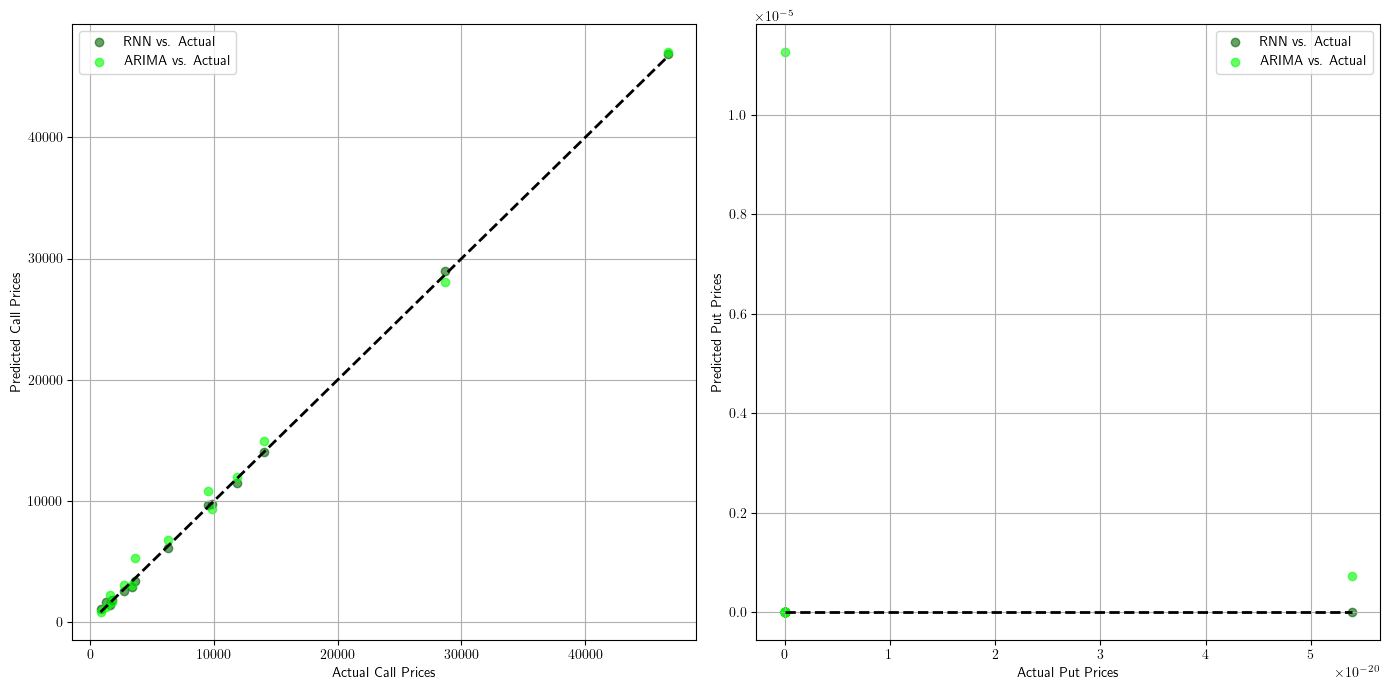

In [5]:
plt.figure(figsize=(14, 7))

# Scatter plot for Call Prices
plt.subplot(1, 2, 1)
plt.scatter(option_prices['call_actual'], option_prices['call_rnn'], label='RNN vs. Actual', alpha=0.6, color='darkgreen')
plt.scatter(option_prices['call_actual'], option_prices['call_arima'], label='ARIMA vs. Actual', alpha=0.6, color='lime')
plt.plot([min(option_prices['call_actual']), max(option_prices['call_actual'])], [min(option_prices['call_actual']), max(option_prices['call_actual'])], 'k--', lw=2)
plt.xlabel('Actual Call Prices')
plt.ylabel('Predicted Call Prices')
plt.legend()
plt.grid(True)

# Scatter plot for Put Prices
plt.subplot(1, 2, 2)
plt.scatter(option_prices['put_actual'], option_prices['put_rnn'], label='RNN vs. Actual', alpha=0.6, color='darkgreen')
plt.scatter(option_prices['put_actual'], option_prices['put_arima'], label='ARIMA vs. Actual', alpha=0.6,  color='lime')
plt.plot([min(option_prices['put_actual']), max(option_prices['put_actual'])], [min(option_prices['put_actual']), max(option_prices['put_actual'])], 'k--', lw=2)
plt.xlabel('Actual Put Prices')
plt.ylabel('Predicted Put Prices')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('reports/images/option_prices_comparison.pdf', dpi=320)
plt.show()

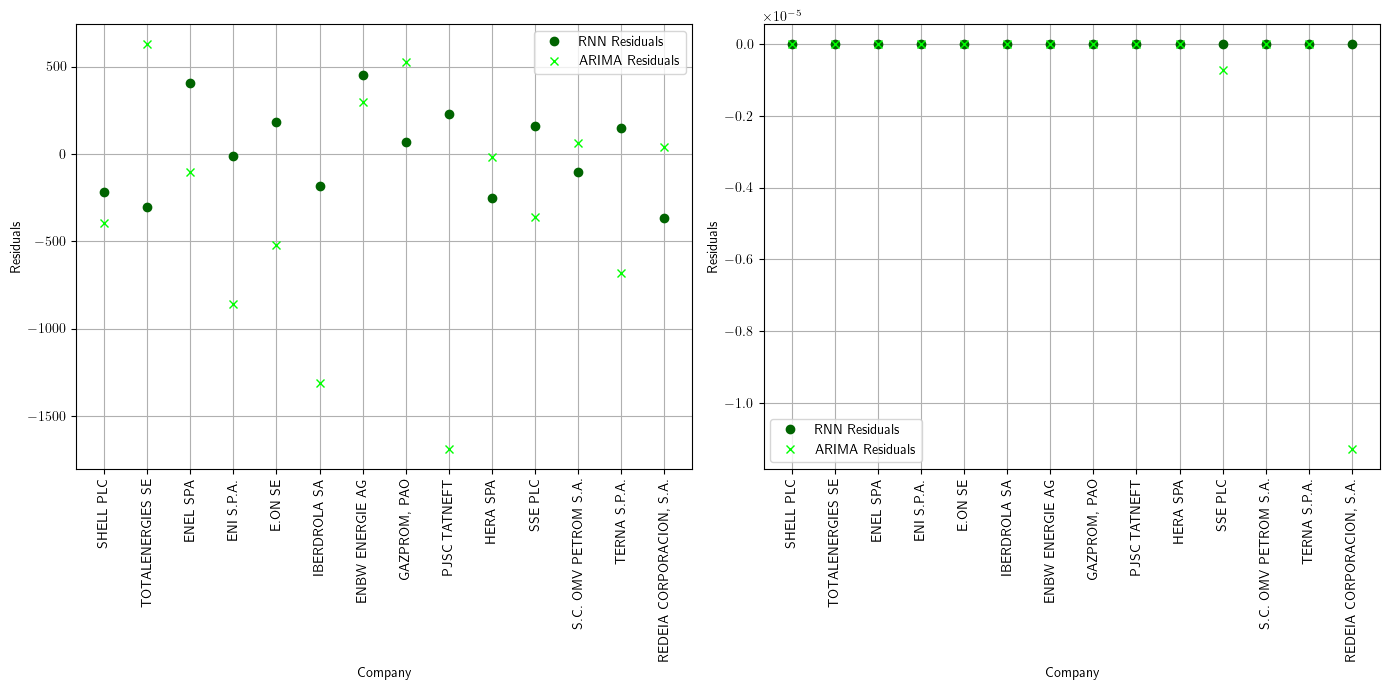

In [6]:
plt.figure(figsize=(14, 7))

# Error plot for Call Prices
plt.subplot(1, 2, 1)
plt.plot(option_prices['company'], option_prices['call_actual'] - option_prices['call_rnn'], label='RNN Residuals', marker='o', linestyle='None',  color='darkgreen')
plt.plot(option_prices['company'], option_prices['call_actual'] - option_prices['call_arima'], label='ARIMA Residuals', marker='x', linestyle='None',  color='lime')
plt.xticks(rotation=90)
plt.xlabel('Company')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

# Error plot for Put Prices
plt.subplot(1, 2, 2)
plt.plot(option_prices['company'], option_prices['put_actual'] - option_prices['put_rnn'], label='RNN Residuals', marker='o', linestyle='None',  color='darkgreen')
plt.plot(option_prices['company'], option_prices['put_actual'] - option_prices['put_arima'], label='ARIMA Residuals', marker='x', linestyle='None',  color='lime')
plt.xticks(rotation=90)
plt.xlabel('Company')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('reports/images/error_plot.pdf', dpi=320)
plt.show()

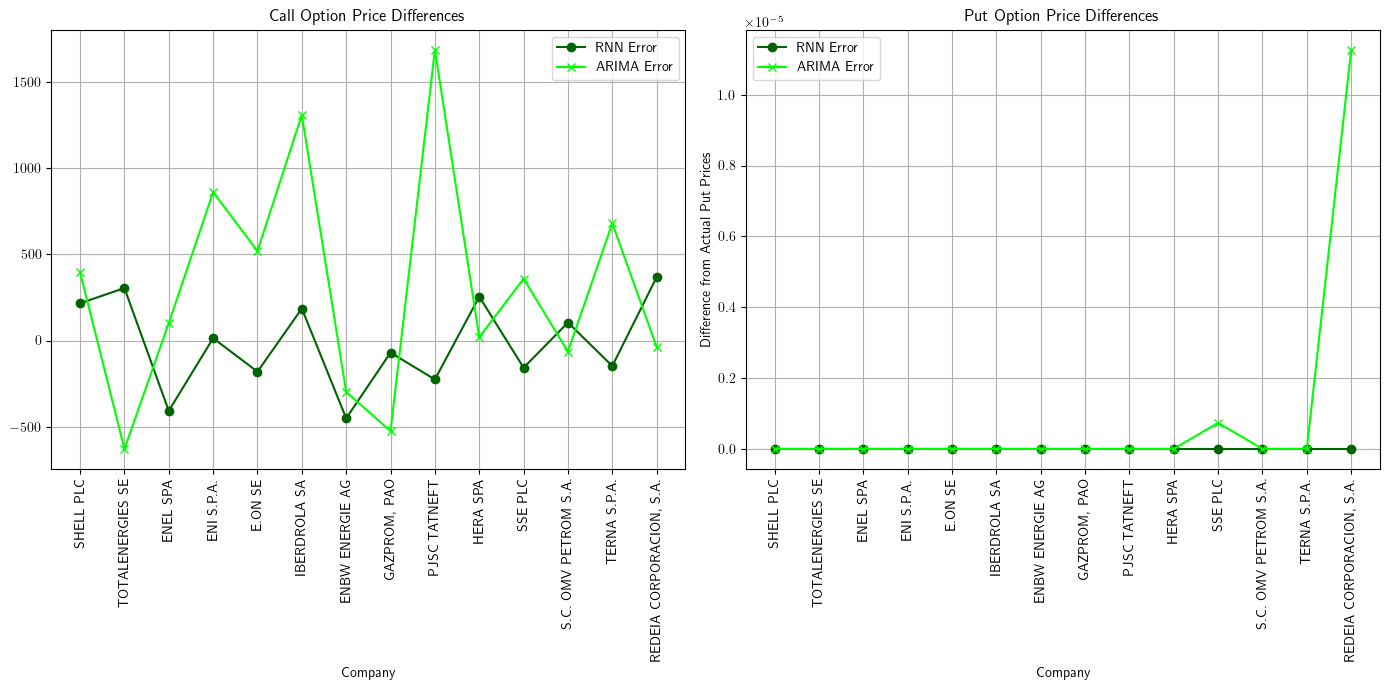

In [7]:
plt.figure(figsize=(14, 7))

# Difference plot for Call Prices
plt.subplot(1, 2, 1)
plt.plot(option_prices['company'], option_prices['call_rnn'] - option_prices['call_actual'], label='RNN Error', marker='o',  color='darkgreen')
plt.plot(option_prices['company'], option_prices['call_arima'] - option_prices['call_actual'], label='ARIMA Error', marker='x',  color='lime')
plt.xticks(rotation=90)
plt.xlabel('Company')
plt.title('Call Option Price Differences')
plt.legend()
plt.grid(True)

# Difference plot for Put Prices
plt.subplot(1, 2, 2)
plt.plot(option_prices['company'], option_prices['put_rnn'] - option_prices['put_actual'], label='RNN Error', marker='o',  color='darkgreen')
plt.plot(option_prices['company'], option_prices['put_arima'] - option_prices['put_actual'], label='ARIMA Error', marker='x',  color='lime')
plt.xticks(rotation=90)
plt.xlabel('Company')
plt.ylabel('Difference from Actual Put Prices')
plt.title('Put Option Price Differences')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('reports/images/difference_plot.pdf', dpi=320)
plt.show()

In [8]:
# Calculate residuals
call_rnn_residuals = option_prices['call_actual'] - option_prices['call_rnn']
call_arima_residuals = option_prices['call_actual'] - option_prices['call_arima']
put_rnn_residuals = option_prices['put_actual'] - option_prices['put_rnn']
put_arima_residuals = option_prices['put_actual'] - option_prices['put_arima']

# Print summary statistics
print("Call Option Prices Residuals:")
print(f"RNN Residuals Mean: {call_rnn_residuals.mean():.4f}, Std: {call_rnn_residuals.std():.4f}")
print(f"ARIMA Residuals Mean: {call_arima_residuals.mean():.4f}, Std: {call_arima_residuals.std():.4f}")

print("\nPut Option Prices Residuals:")
print(f"RNN Residuals Mean: {put_rnn_residuals.mean():.4f}, Std: {put_rnn_residuals.std():.4f}")
print(f"ARIMA Residuals Mean: {put_arima_residuals.mean():.4f}, Std: {put_arima_residuals.std():.4f}")

Call Option Prices Residuals:
RNN Residuals Mean: 13.7377, Std: 261.3256
ARIMA Residuals Mean: -312.9609, Std: 663.5888

Put Option Prices Residuals:
RNN Residuals Mean: -0.0000, Std: 0.0000
ARIMA Residuals Mean: -0.0000, Std: 0.0000
